# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

## Setup

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.5 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Adicionado
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import pathlib


## Prepare the data

In [ ]:
num_classes = 2
input_shape = (224, 224, 3)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

# print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


In [ ]:
# setting train and test dir
train_dir = '/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/BreakHis400x_Balanceado/train_set'
val_dir = '/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/BreakHis400x_Balanceado/validation_set'
test_dir = '/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/BreakHis400x_Balanceado/test_set'

IMG_SIZE = (224,224)

train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)

# ImageDataGenerator(rescale=1/255.,rotation_range=20, 
#                                    zoom_range=0.2, width_shift_range=0.2,
#                                    height_shift_range=0.2,shear_range=0.2,
#                                    horizontal_flip=True, vertical_flip=True,
#                                    brightness_range=(0.5,1.5))

validation_datagen = ImageDataGenerator(rescale=1/255.)


test_datagen = ImageDataGenerator(rescale=1/255.)

# # Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=2074,
                                              class_mode='categorical', shuffle=True)

validation_data = validation_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=180,
                                                   class_mode='categorical', shuffle=True)

test_data = test_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, 
                                             batch_size=180, class_mode='categorical')

Found 2074 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


In [ ]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/BreakHis400x_Balanceado/train_set')

# creating a list of class_names from the subdirectory /train
class_names = np.array(sorted([item.name for item in data_dir_train.glob('*')]))
print(f'Types: {class_names}')

Types: ['benign' 'malignant']


In [ ]:
x_train = np.array(train_data[0][0])
y_train = np.array(train_data[0][1])

x_val = np.array(validation_data[0][0])
y_val = np.array(validation_data[0][1])

x_test = np.array(test_data[0][0])
y_test = np.array(test_data[0][1])

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (2074, 224, 224, 3) - y_train shape: (2074, 2)
x_val shape: (180, 224, 224, 3) - y_val shape: (180, 2)
x_test shape: (180, 224, 224, 3) - y_test shape: (180, 2)


## Configure the hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 250
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        # layers.RandomRotation(factor=0.02),
        # layers.RandomZoom(
        #     height_factor=0.2, width_factor=0.2
        # ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


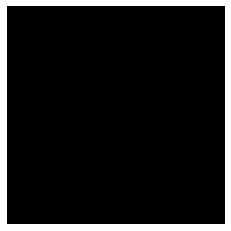

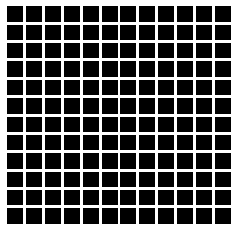

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


### Plot Confusion Matrix

In [ ]:
#Função de geração da matriz de confusão
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=11):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig  

## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    model.summary()
    # ### Conjunto de Teste ###

    # print ("### Matriz de confusão para o conjunto de teste ###")
    # num_test = test_data.samples

    # #Confution Matrix
    # Y_pred = model.predict(x_test, verbose=1)

    # test_preds = np.argmax(Y_pred, axis=-1)
    # l=test_preds.shape[0]
    # test_trues = test_data.classes
    # cm =confusion_matrix(test_trues[:l], test_preds)

    # print_confusion_matrix(cm, ["benigno", "maligno"], figsize = (10,7), fontsize=11)

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/250
9/9 [==============================] - 14s 637ms/step - loss: 6.8248 - accuracy: 0.6635 - top-5-accuracy: 1.0000 - val_loss: 5.6921 - val_accuracy: 0.5111 - val_top-5-accuracy: 1.0000
Epoch 2/250
9/9 [==============================] - 5s 530ms/step - loss: 1.2580 - accuracy: 0.7835 - top-5-accuracy: 1.0000 - val_loss: 0.6898 - val_accuracy: 0.7444 - val_top-5-accuracy: 1.0000
Epoch 3/250
9/9 [==============================] - 4s 501ms/step - loss: 0.4455 - accuracy: 0.8308 - top-5-accuracy: 1.0000 - val_loss: 0.6627 - val_accuracy: 0.7556 - val_top-5-accuracy: 1.0000
Epoch 4/250
9/9 [==============================] - 4s 493ms/step - loss: 0.3955 - accuracy: 0.8607 - top-5-accuracy: 1.0000 - val_loss: 0.5647 - val_accuracy: 0.7667 - val_top-5-accuracy: 1.0000
Epoch 5/250
9/9 [==============================] - 5s 514ms/step - loss: 0.3430 - accuracy: 0.8737 - top-5-accuracy: 1.0000 - val_loss: 0.4599 - val_accuracy: 0.8167 - val_top-5-accuracy: 1.0000
Epoch 6/250
9/9 [=======

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.

dict_keys(['loss', 'accuracy', 'top-5-accuracy', 'val_loss', 'val_accuracy', 'val_top-5-accuracy'])


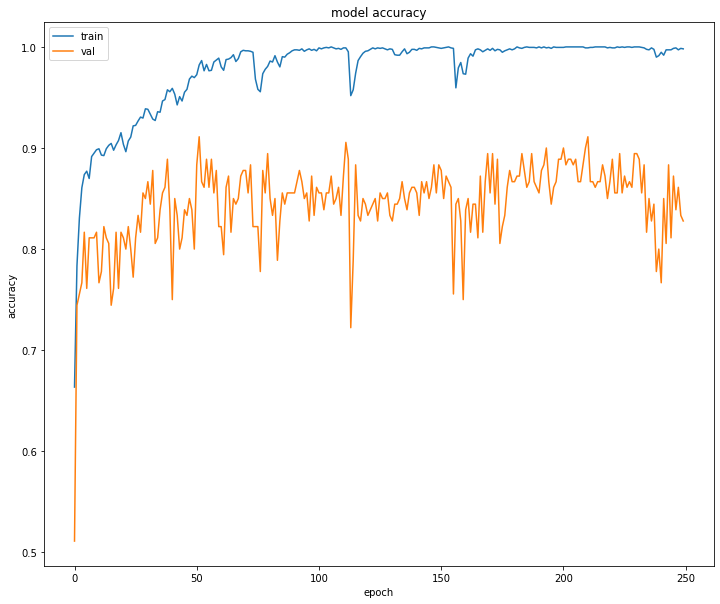

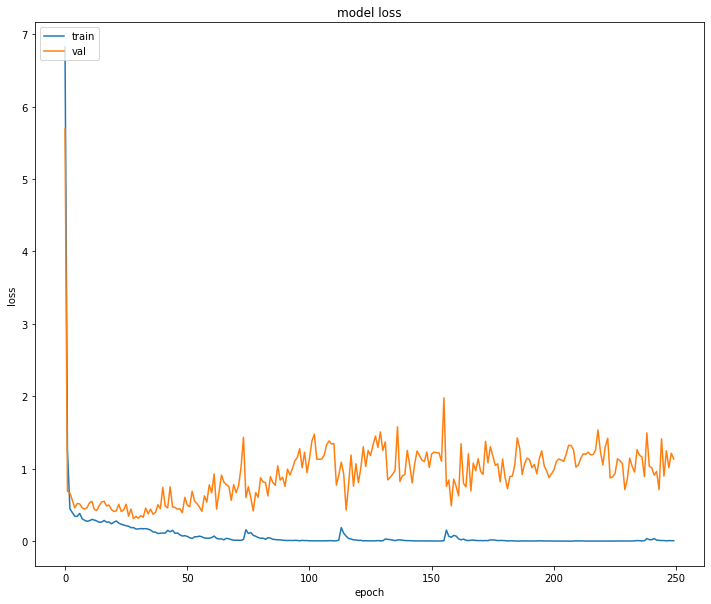

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(12,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()
# summarize history for loss
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()

In [ ]:
def get_img_array(img_path, size):
    # Read in the image
    img = tf.io.read_file(img_path)
    
    # Decode the read file to a tensor
    img = tf.image.decode_image(img)
    
    # Resize the image
    img = tf.image.resize(img, size=[size, size])
    
    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = np.array(img)
    # We add a dimension to transform our array into a "batch"
    # of 
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    
    return array

    # def get_img_array(img):
    
    # # `array` is a float32 Numpy array of shape (299, 299, 3)
    # array = keras.preprocessing.image.img_to_array(img)
    # # We add a dimension to transform our array into a "batch"
    # # of size (1, 299, 299, 3)
    # array = np.expand_dims(array, axis=0)
    # return array

In [ ]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
        
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output#[0]
    #print(np.expand_dims(last_conv_layer_output,axis=0))
    #print(pooled_grads[..., tf.newaxis])
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_gradcam(img, heatmap, alpha=0.0055):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [ ]:
#vit_cam = keras.models.load_model('')

Predicted:
 [ 4.1841493 -3.095973 ]


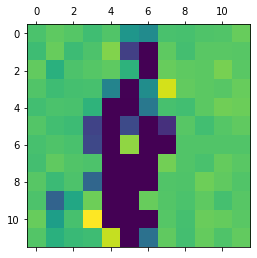

In [ ]:
#test_image = next(iter(test_data))[0]
# Prepare image
img_array=get_img_array('/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/brecahad_test_set/Case_7-06.png', 224)

last_conv_layer_name = 'layer_normalization_33'
# Remove last layer's softmax
vit_classifier.layers[-1].activation = None
# Print what the top predicted class is
preds = vit_classifier.predict(img_array)
print("Predicted:\n", preds[0])
# Generate class activation heatmap
heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
# Display heatmap
plt.matshow(heatmap)

plt.show()

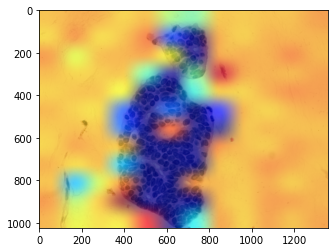

In [ ]:
#fig, axis = plt.subplots(3, 2, figsize=(10, 10))
img_array = get_img_array('/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/brecahad_test_set/Case_7-06.png', size=224)
images = plt.imread('/content/drive/MyDrive/Disciplina 10 - Visão Computacional 2/breakHis_dataset/brecahad_test_set/Case_7-06.png')
#img = tf.image.resize(images, size=[224, 224])
# Remove last layer's softmax
vit_classifier.layers[-1].activation = None
# Print what the top predicted class is
preds = vit_classifier.predict(img_array)
heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
display_gradcam(images, heatmap)

plt.imshow(display_gradcam(images, heatmap))


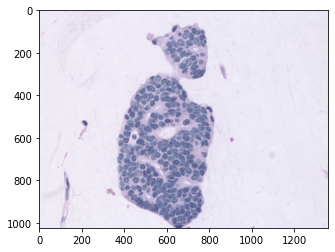

In [ ]:
plt.imshow(images)